# Human electrocardiogram basic analysis

### Ana Daniela del Río Pulido and Erin C. McKiernan

### Facultad de Ciencias, UNAM

In this practical, students will graph and analyze electrocardiogram (ECG) data using Python 3. They will obtain the different components of the ECG. Raw recordings for this practical can be collected by students, or they can work with existing recordings from our repository.

## Human electrocardiogram
The human electrocardiogram (ecg) is a physiological signal that is measured by placing electrodes that record the heart's voltage changes. Each part of the obtained signal corresponds to a particular action of the heart [Boron and Boulpaep, 2012] [BackyardBrains, 2017] [Kantz and Schreiber, 2004, pg. 344], this can be seen in the following figure. One period of the electrical signal of the heart is called the PQRST wave complex.
<img src="Images/ecg.png" width ="500" height ="200" > 
<img src="Images/ecg2.jpg" width ="500" height ="200" > 
Taken from: https://litfl.com/wp-content/uploads/2018/10/ECG-waves-segments-and-intervals-LITFL-ECG-library-3.jpg

# Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules needed for plotting figures, create animations, etc. We include commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import butter, lfilter, filtfilt #for filtering data
from statistics import stdev
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Extracting and graphing the data

ECG recordings were obtained using the Backyard Brains Heart and Brain Spiker Box. The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data. We can extract the number of recording channels, sampling rate, etc.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

Obtaining data from several recordings and plotting.

In [5]:
#Test data
nice = ["C1", "C2", "C3"]

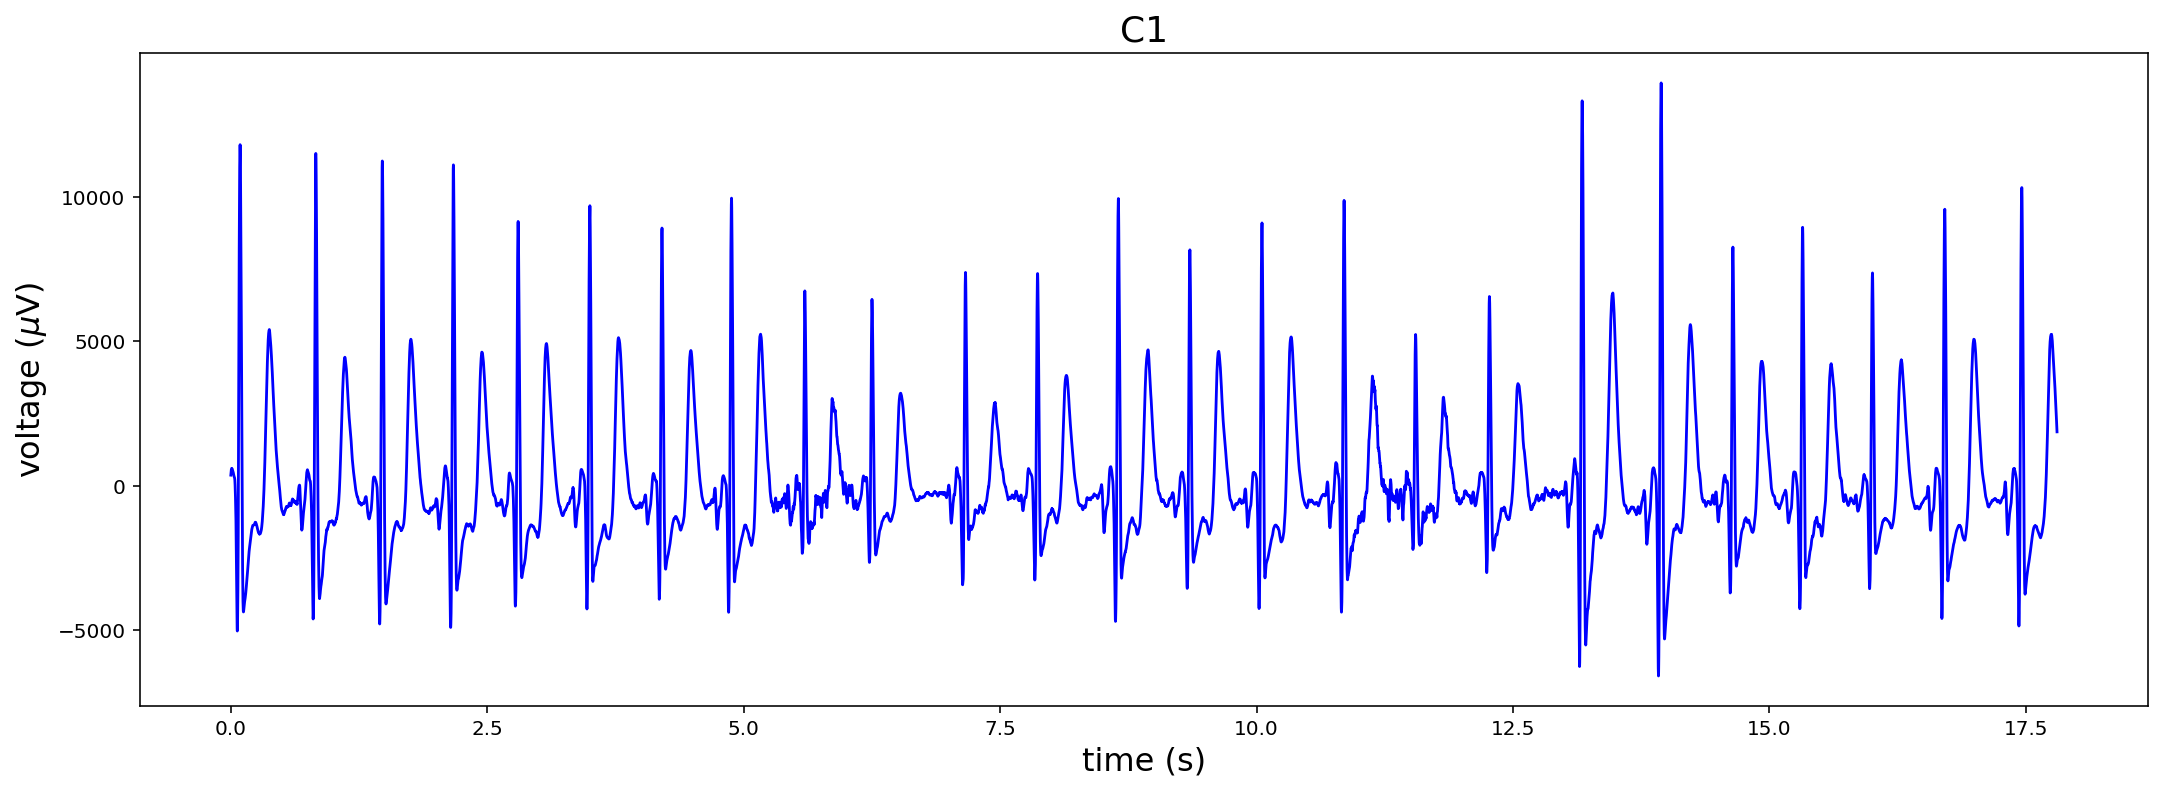

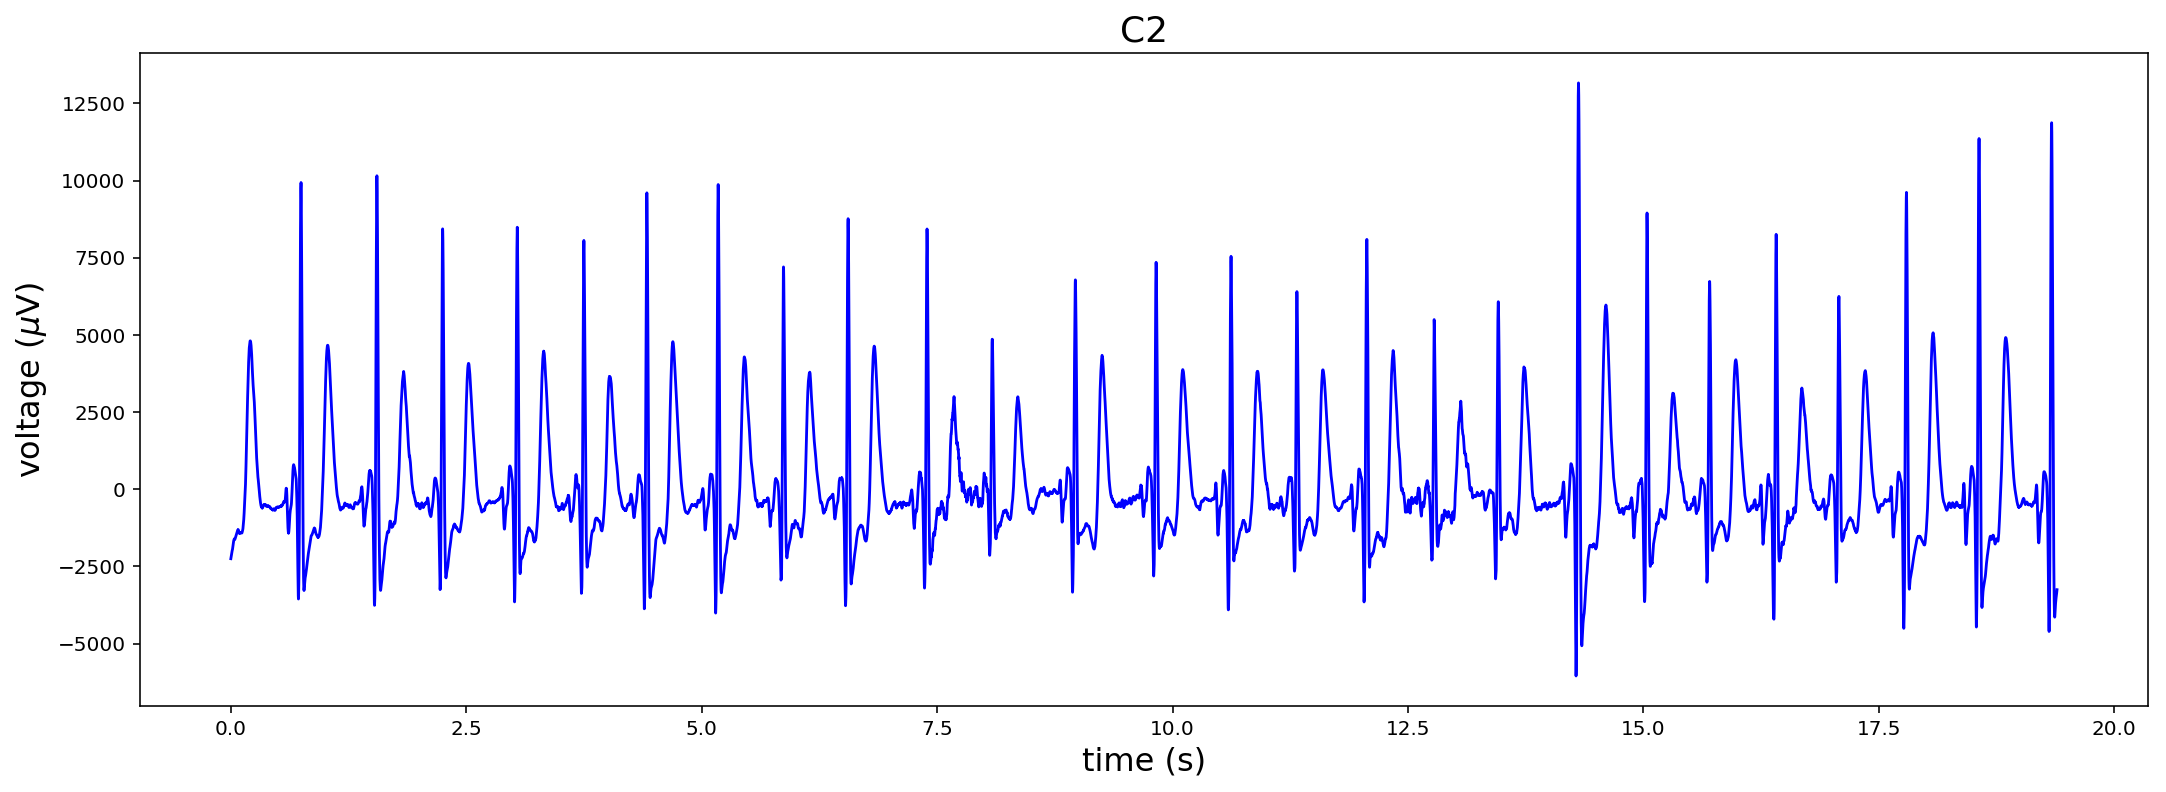

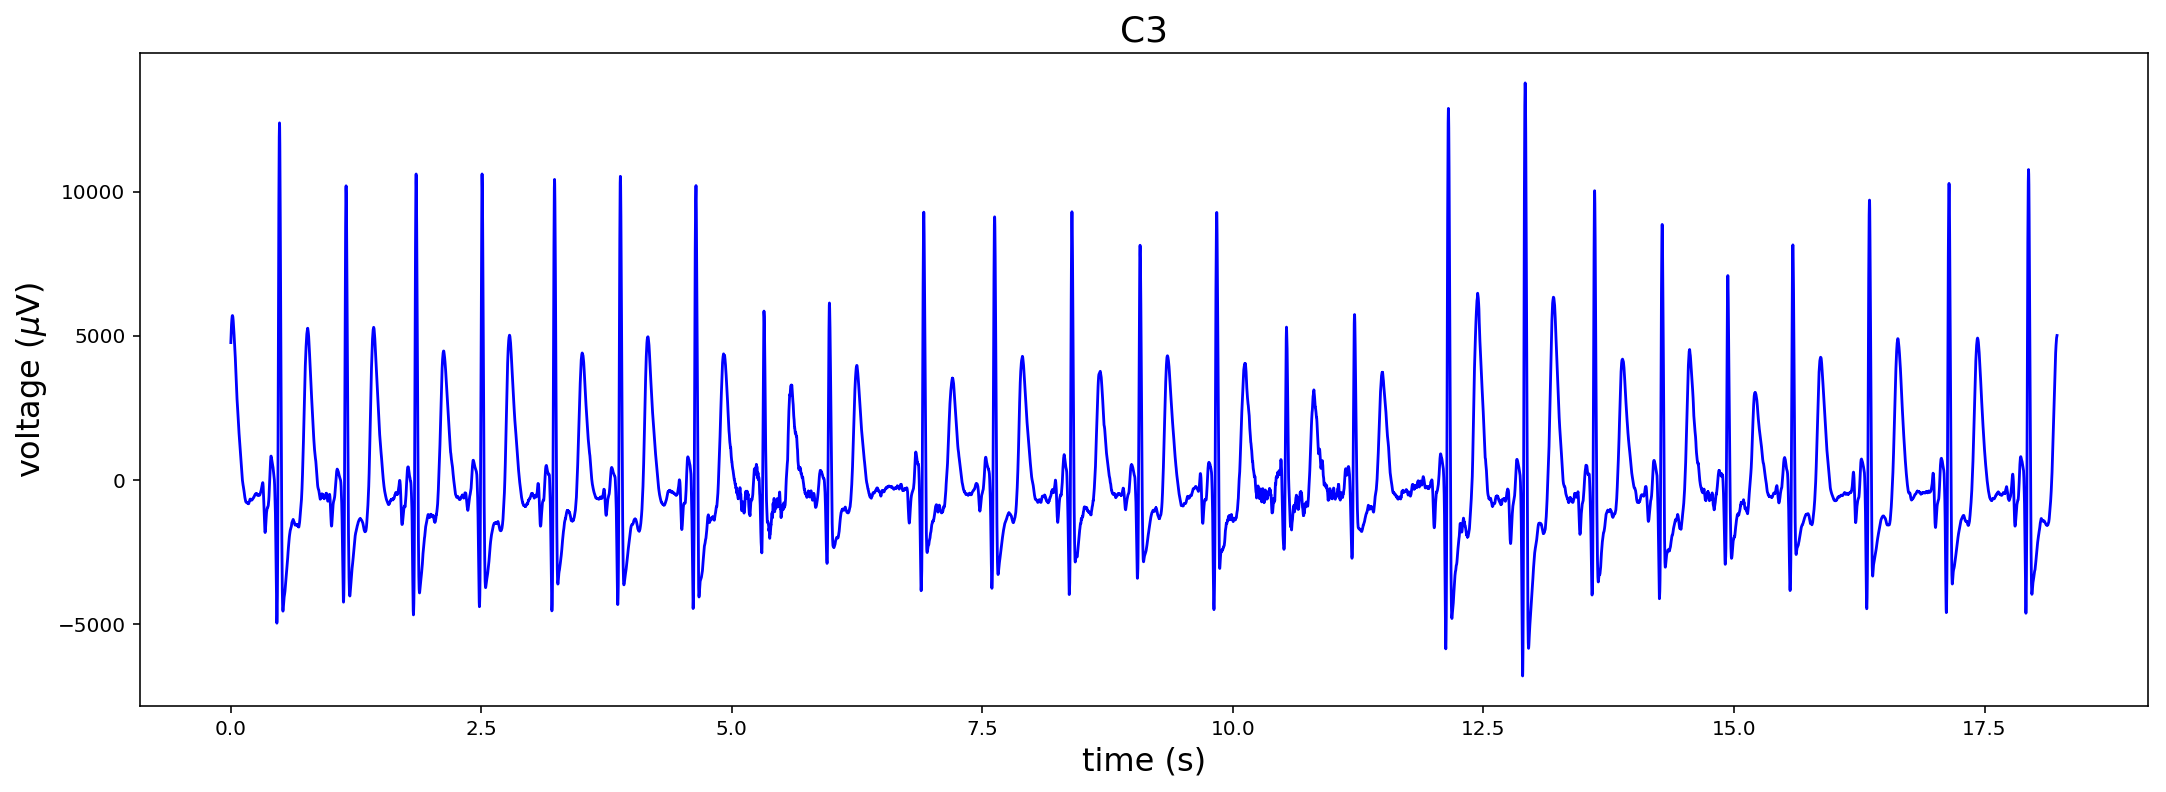

In [6]:
for i in range(0, len(nice)):
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    # Plotting EMG signal
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    plt.title(nice[i])
    plt.show()

For the algorithm to work properly, choose a recording with the following characteristics:

- Stable baseline.
- R peaks muct be higher than the maximum value of the T wave.
- R peaks have the same amplitude in each cycle.

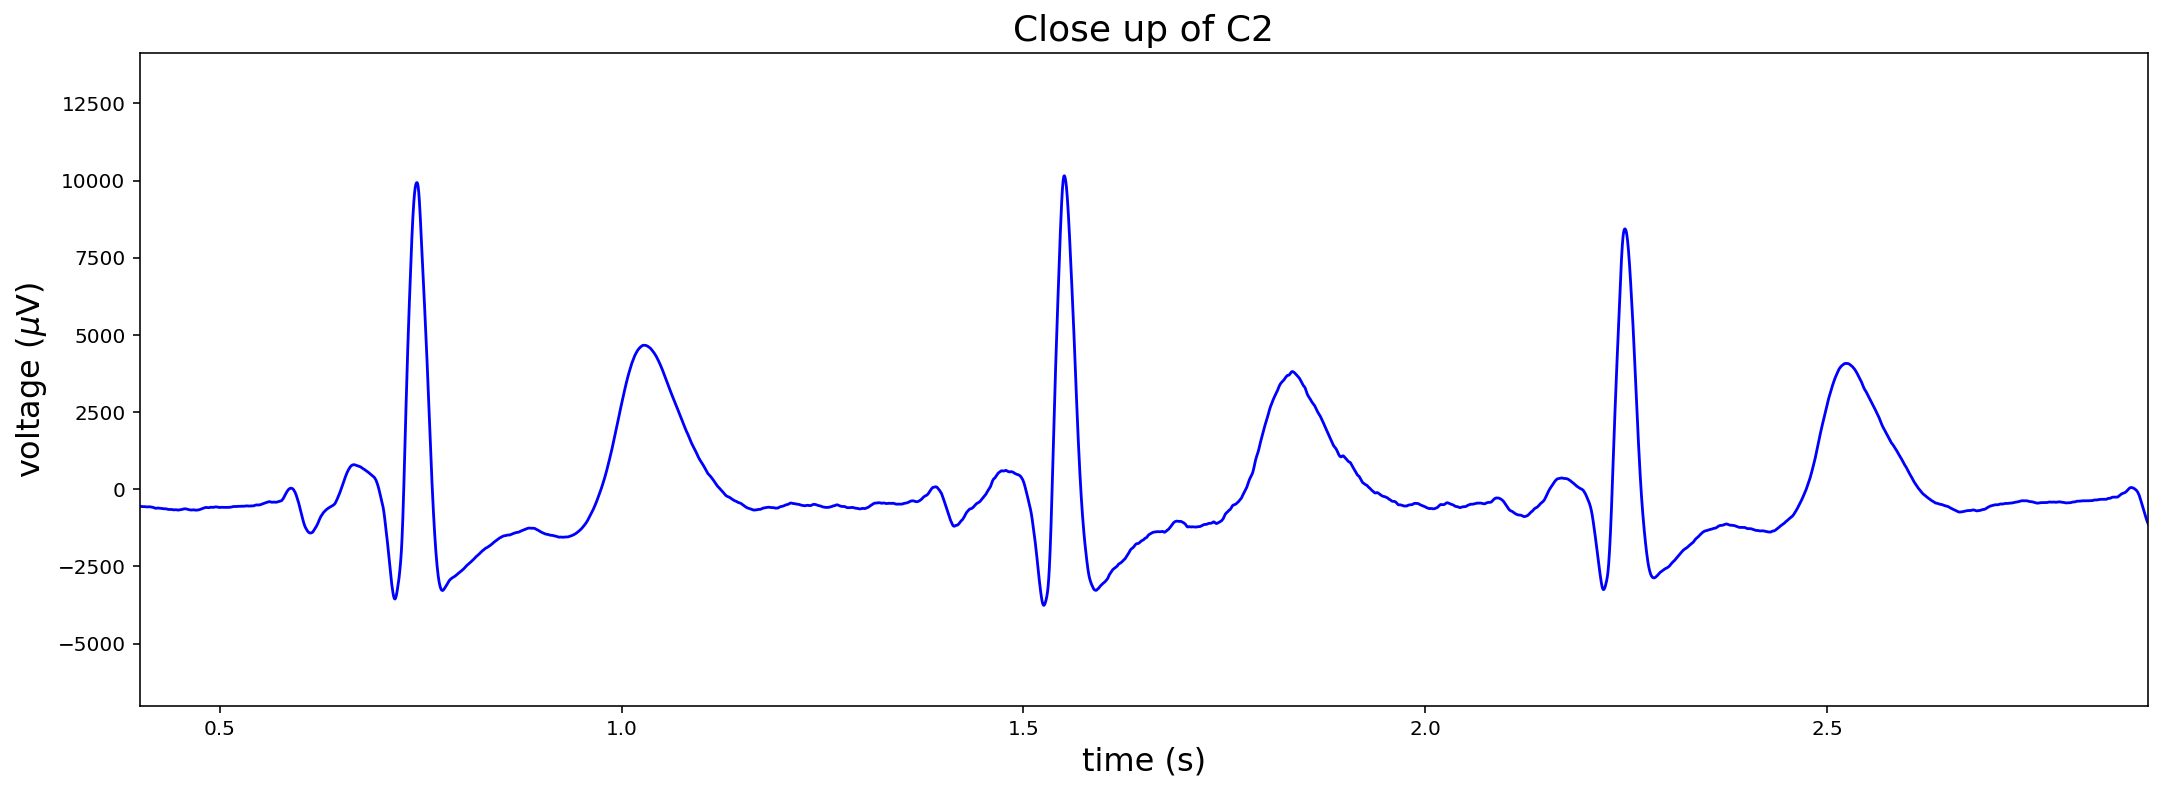

In [7]:
#Obtaining data
timeECG, waveData = ecg("ECG_samples/C2.wav")

# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.xlim(.40,2.9)
plt.title("Close up of C2")
plt.show()

For the algorithm to work properly, we will need to cut the recording. We want to have complete cycles, so find the time before the first P wave starts ``n1`` and the time after the last T wave ``n2``. Notice that if you have noise in your recording, you also want to cut that part.

Now, let's plot the raw ECG signal.

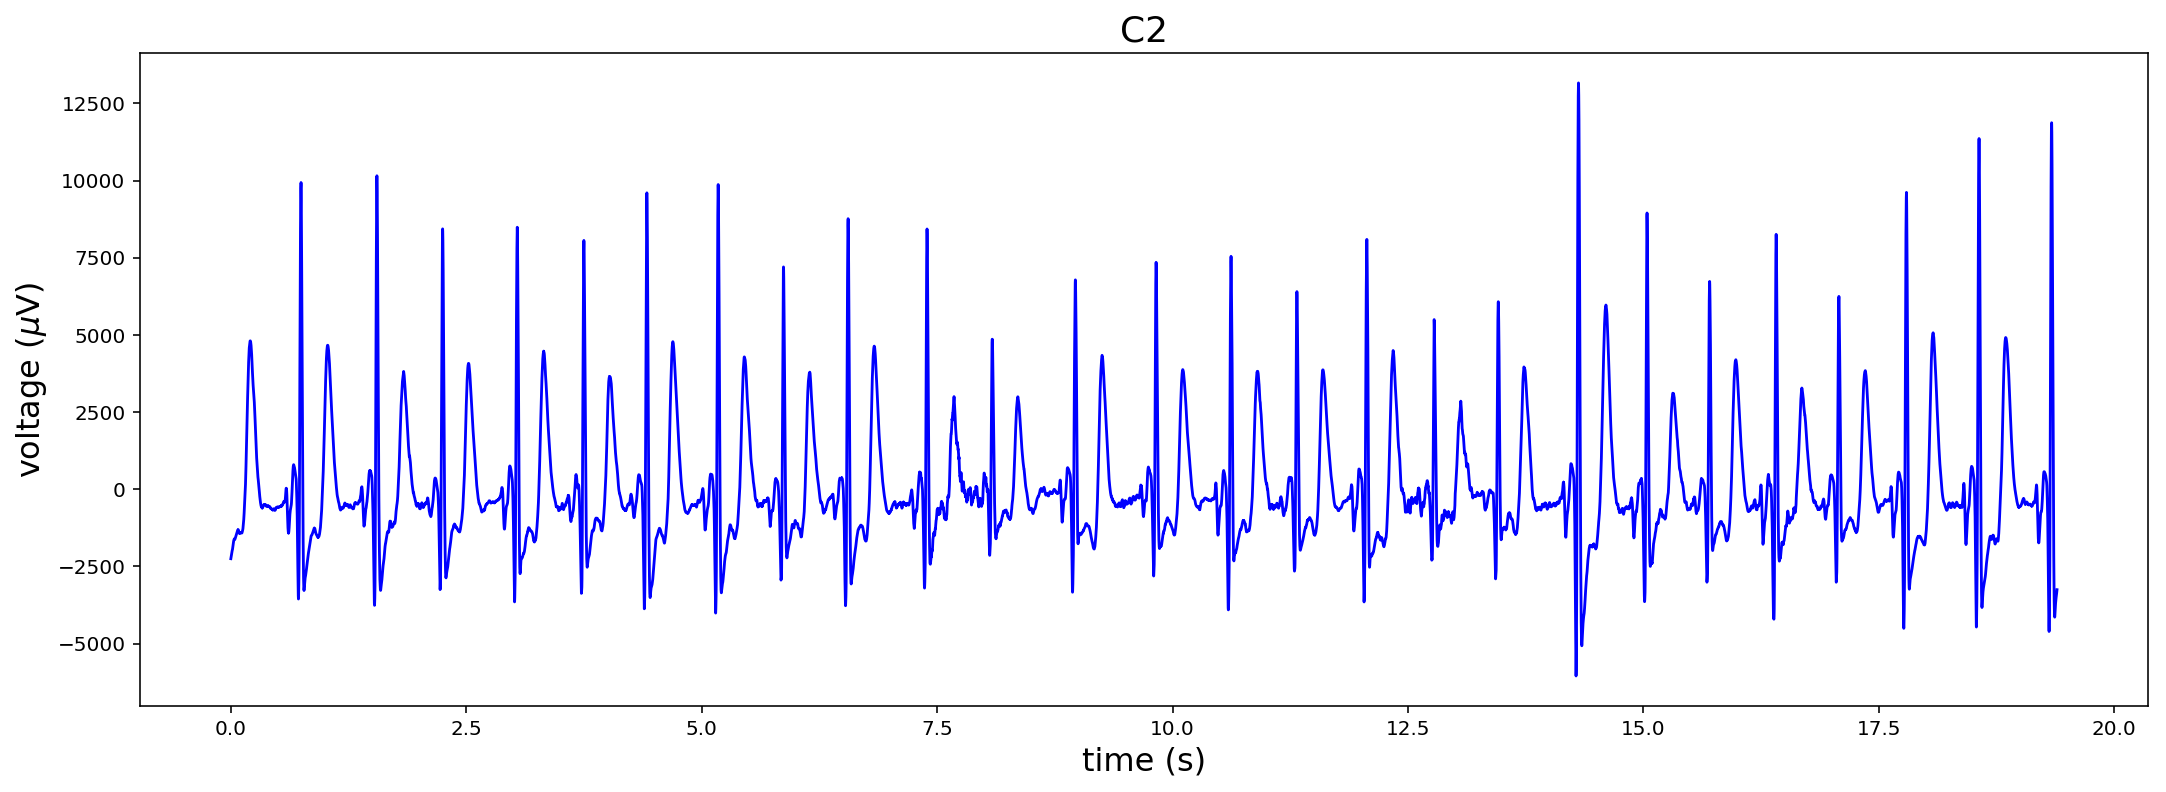

In [8]:
# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.title("C2")
plt.show()

In [9]:
#Seconds at which we are going to cut the recording
n1 = .40
n2 = 7.9

m1 = int(n1*10000)
m2 = int(n2*10000)

print(timeECG[m1])
print(timeECG[m2])

0.4000020628020071
7.900040740339641


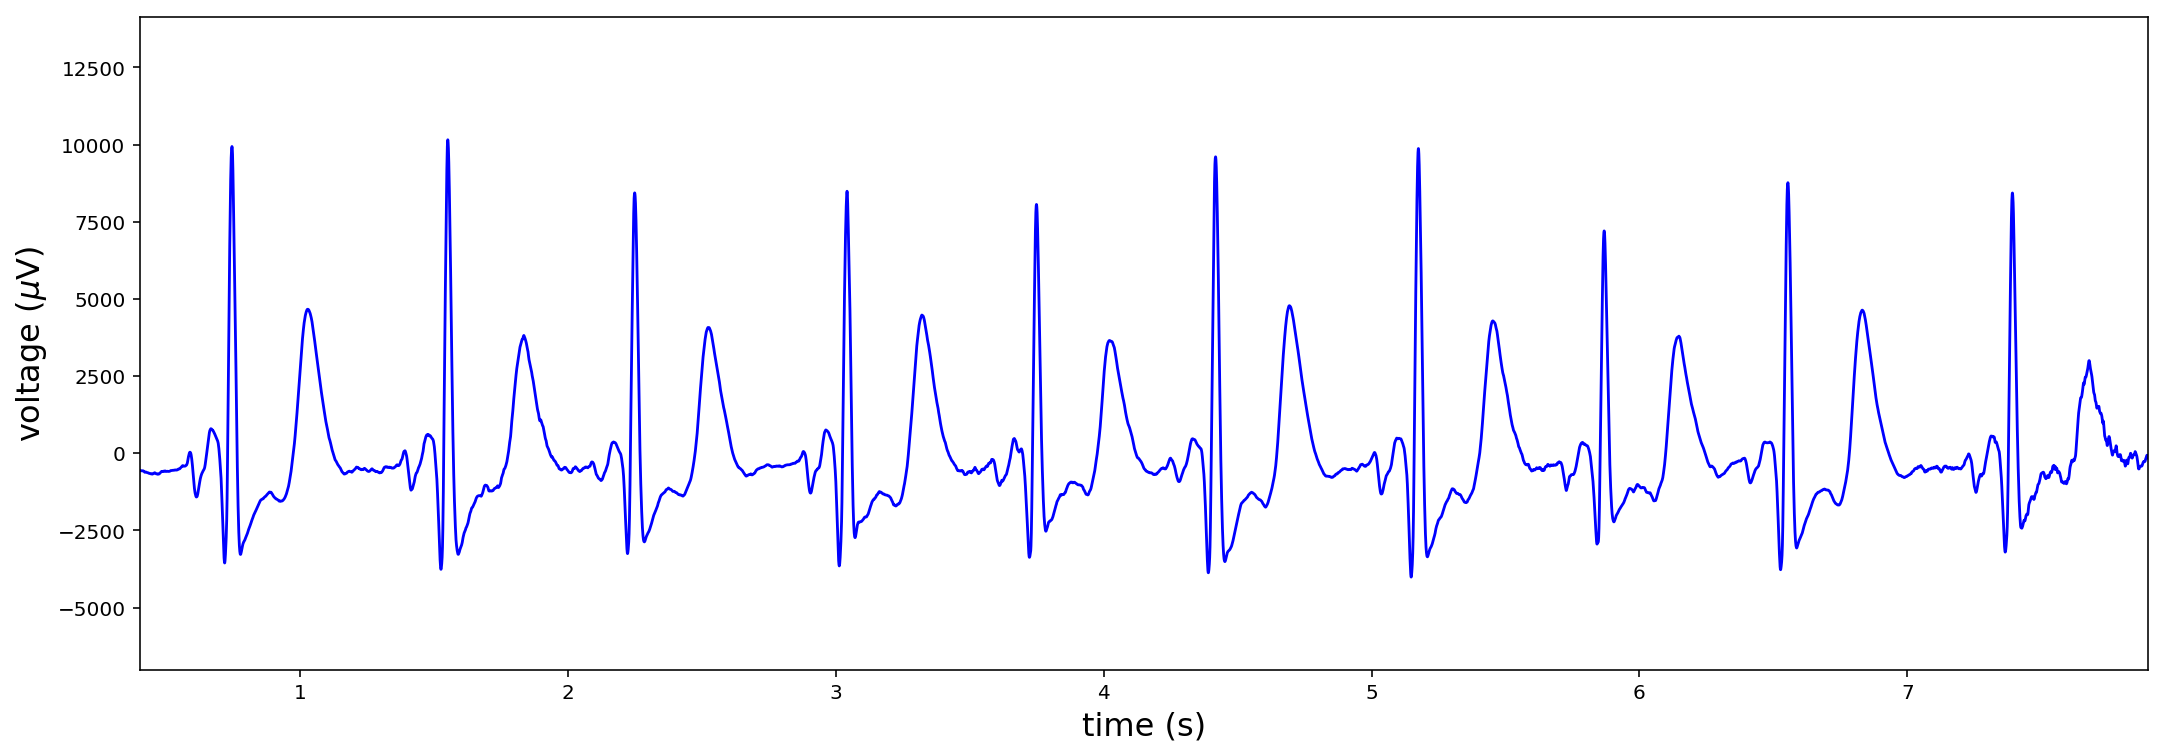

In [10]:
# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.xlim(timeECG[m1],timeECG[m2])
plt.show()

Cutting the recording with the previous parameters. Notice that if you run the next cell twice, the data will be cut again.

In [11]:
timeECG, waveData = timeECG[m1:m2], waveData[m1:m2]

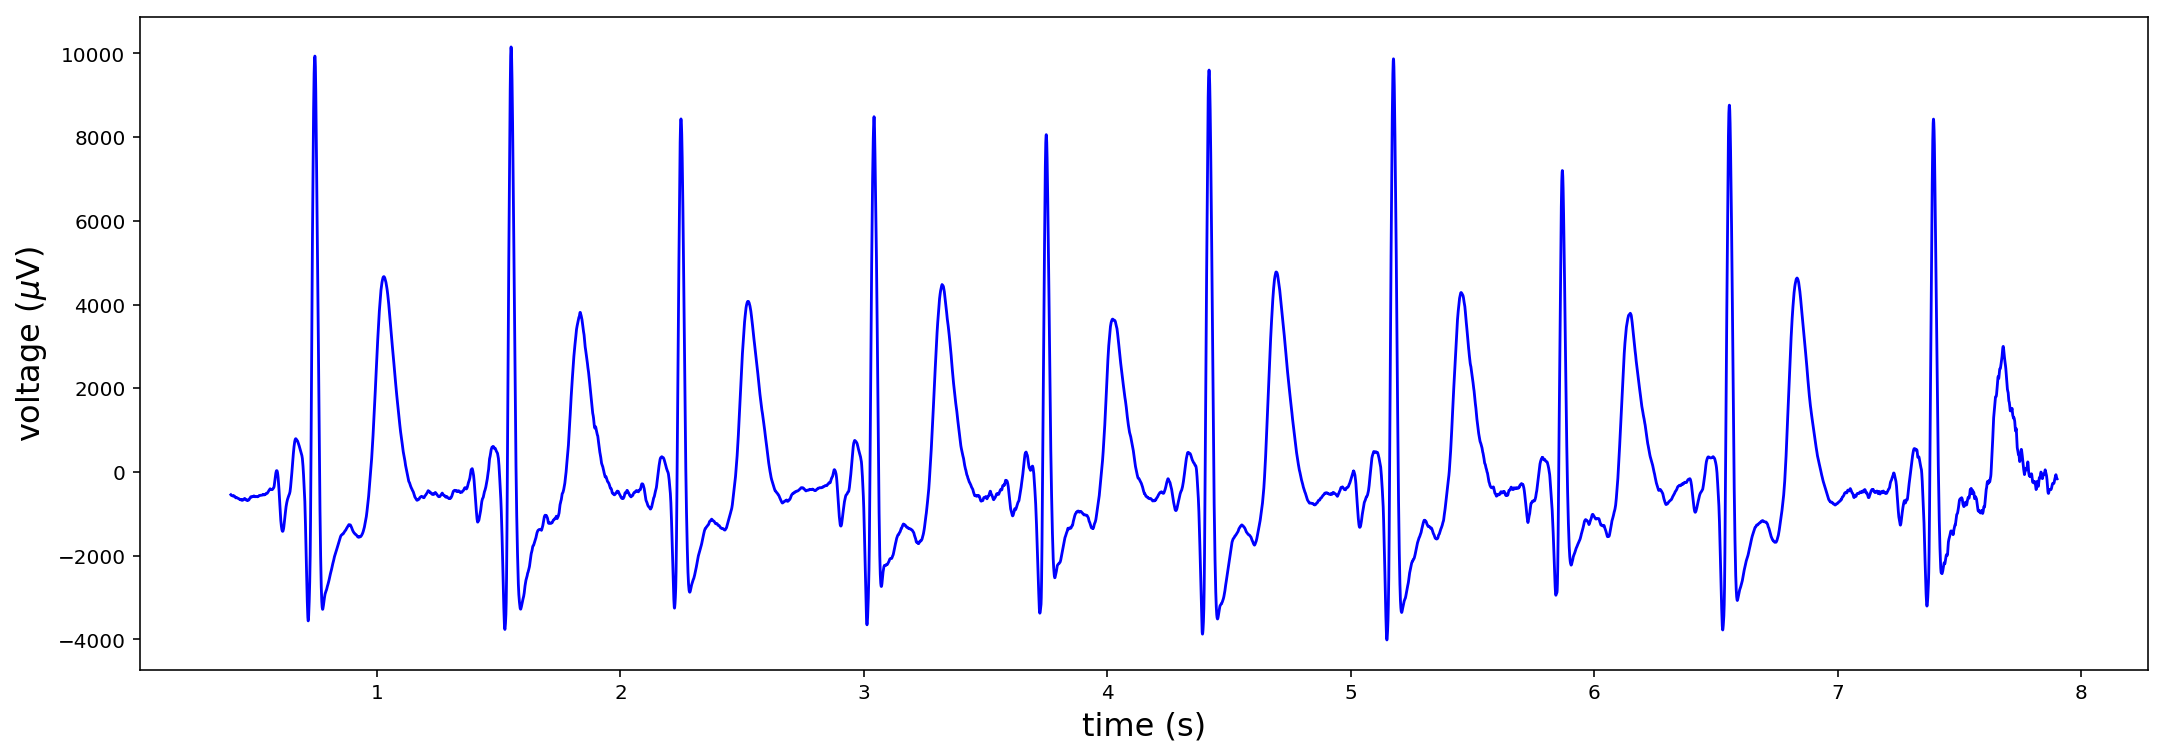

In [12]:
# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.show()

# Algorithm for detecting ECG components

The idea underlying this algorithm is finding a good ECG recording.

Then, detecting the maximum values (R peaks) in a certain time window (based on a threshold).

Afterwards, based on certain time delays from the R peak, we will obtain other parts of the periodic signal.

These components can be minimum values (Q and S) or we will obtain the time derivative and detect when an inflection point (P_wave and T-wave) occurs.

# R peaks

Based on the R peak detection, we will be able to calculate the heart frequency and R-R intervals.

The following function creates an array of values which surpass a certain threshold. Afterwards, it determines the maximum value of this array and adds it in the R-vector. And this is repeated until the end of the time series.

In [13]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, higher the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if the two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) - min(waveData)
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

Trying out the function and plotting.

In [14]:
mxs_indices = detecta_maximos_locales(timeECG, waveData)

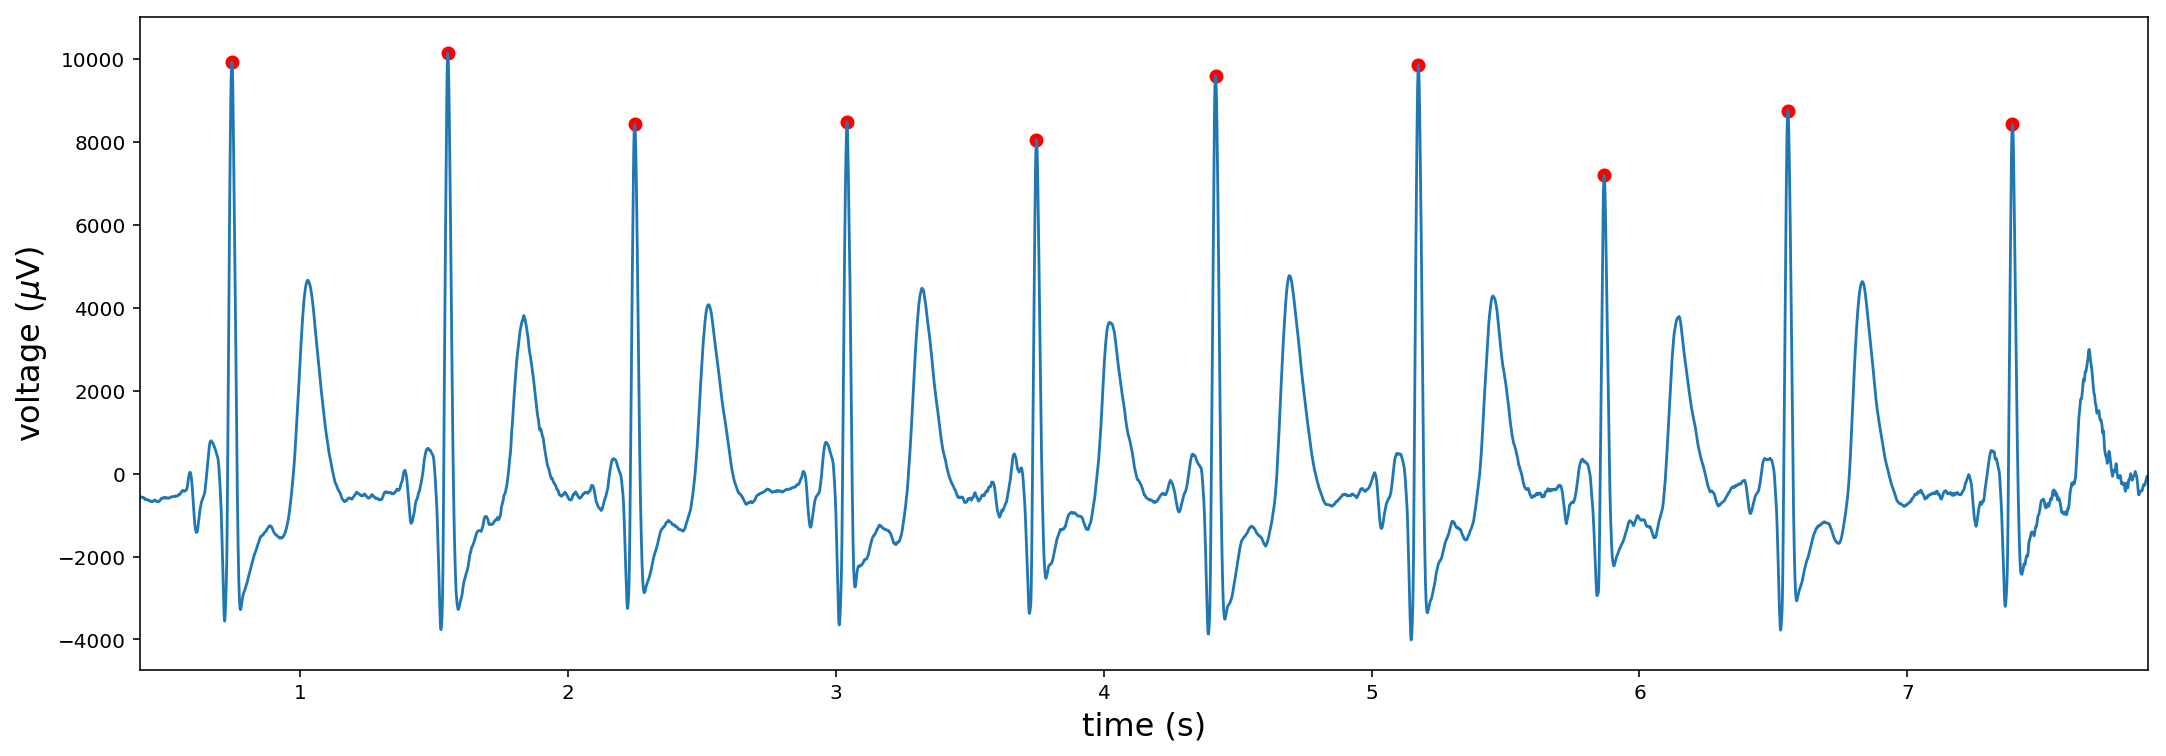

In [15]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timeECG),max(timeECG))
plt.plot(timeECG, waveData)
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.show()

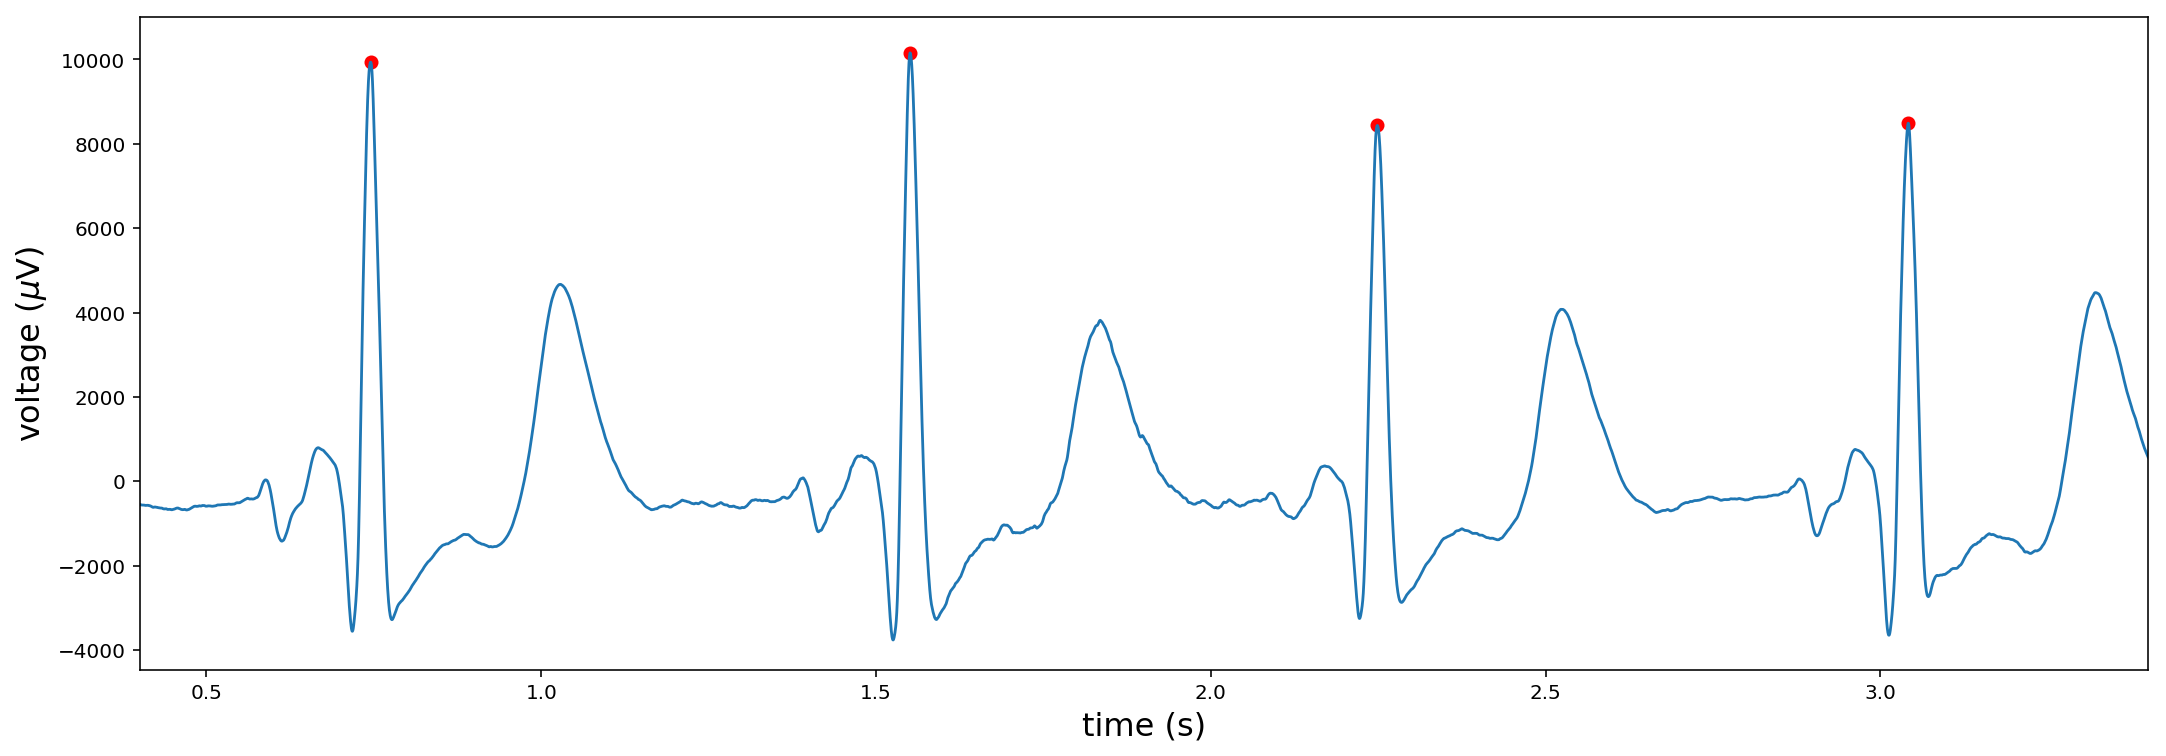

In [16]:
# Close up from an initial second to an end second
init_sec = 0
end_sec = 3
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[end_sec*10000])
plt.plot(timeECG[init_sec*10000:end_sec*10000], waveData[init_sec*10000:end_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.show()

# Heart frequency and R-R intervals

In [17]:
mean_bpm = 60*(len(mxs_indices)/(timeECG[-1]-timeECG[0]))
print("Beats per minute:", mean_bpm)

Beats per minute: 80.00065411711437


In [18]:
heart_rate = [(60/(timeECG[mxs_indices[i+1]]-timeECG[mxs_indices[i]])) for i in range(0, len(mxs_indices)-1)]
time = timeECG[mxs_indices]

mean_vec = [mean_bpm for i in range(0, len(time)-1)]
std_vec_plus = [mean_bpm+stdev(heart_rate) for i in range(0, len(time)-1)]
std_vec_minus = [mean_bpm-stdev(heart_rate) for i in range(0, len(time)-1)]

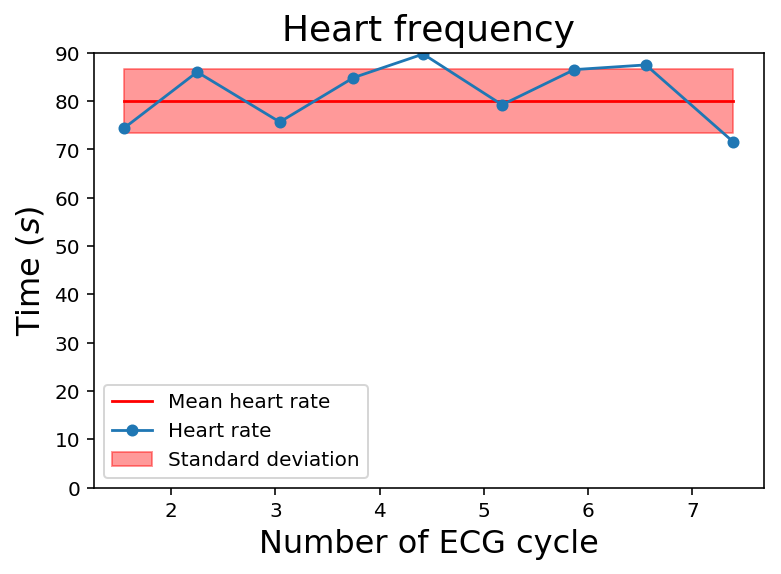

In [19]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean heart rate")
plt.plot(time[1:], heart_rate, markersize=5, marker = "o", label="Heart rate")
plt.ylim((0, 90))
plt.title("Heart frequency")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

In [20]:
# If the input of this function is time, the intervals will be given in those same units
# Obtaining the indexes at which the R peaks occur.
def R_intervals(time_indices):
    length = len(time_indices)
    intervals = np.zeros(length-1)
    
    for i in range(0, length-1):
        intervals[i] = time_indices[i+1]-time_indices[i]
    
    return intervals

In [21]:
xx = R_intervals(timeECG[mxs_indices])
mean_rr = np.mean(xx)
print("Mean R-R interval: ",mean_rr)

mean_vec = [mean_rr for i in range(0, len(time)-1)]
std_vec_plus = [mean_rr+stdev(xx) for i in range(0, len(time)-1)]
std_vec_minus = [mean_rr-stdev(xx) for i in range(0, len(time)-1)]

Mean R-R interval:  0.7386149201323173


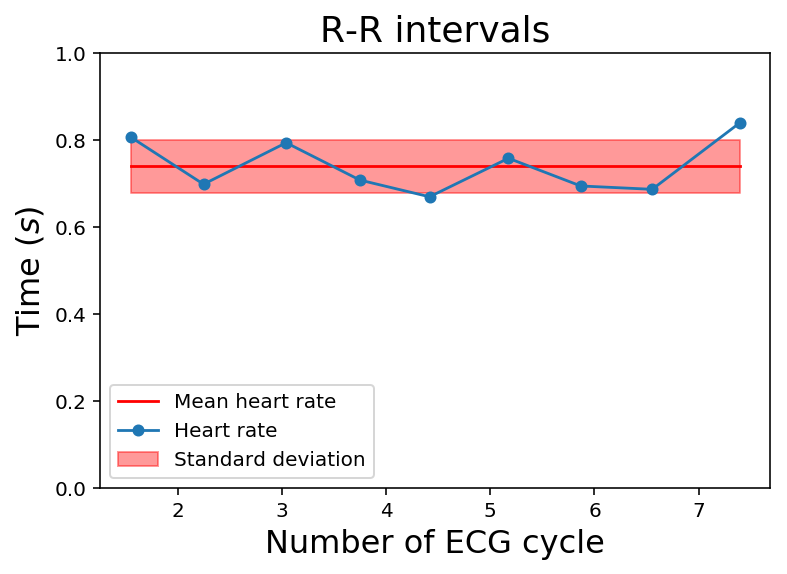

In [22]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean heart rate")
plt.plot(time[1:], xx, markersize=5, marker = "o", label="Heart rate")
plt.ylim((0, 1))
plt.title("R-R intervals")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

Notice how the previous functions are measuring the R intervals, but in different ways.

Heart frequency measures beats per minute:
$$\frac{60}{time(Rpeak_{i+1})-time(Rpeak_i)}$$
R
-R intervals measure:
$$time(Rpeak_{i+1})-time(Rpeak_i)$$

That is why one function is the inverse of the other times a constant value. Try the following cell to prove the affirmations.

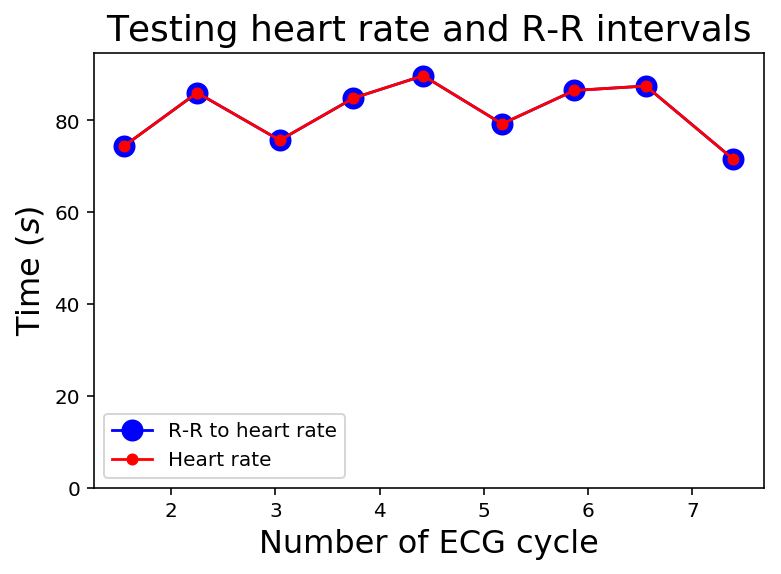

In [23]:
test = [60/xx[i] for i in range(0, len(xx))]

plt.plot(time[1:], test, markersize=10, marker = "o", label="R-R to heart rate", c = "blue")
plt.plot(time[1:], heart_rate, markersize=5, marker = "o", label="Heart rate", c="red")

plt.ylim((0, max(test)+5))
plt.title("Testing heart rate and R-R intervals")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

# Components of ECG

## QRS complex

Considering that the normal QRS width is 0.07-0.1 s [Larkin, 2019], we will obtain the minimum value of the recording in both the left and right interval of the R peak.

In [24]:
mins_try = []
i=0

for R_peak_i in mxs_indices:
    left_interval = waveData[R_peak_i-700:R_peak_i]
    right_interval = waveData[R_peak_i:R_peak_i+700]
    
    mins_try.append(R_peak_i - 700 + (list(left_interval).index(min(left_interval))) )
    mins_try.append(R_peak_i + (list(right_interval).index(min(right_interval))) )

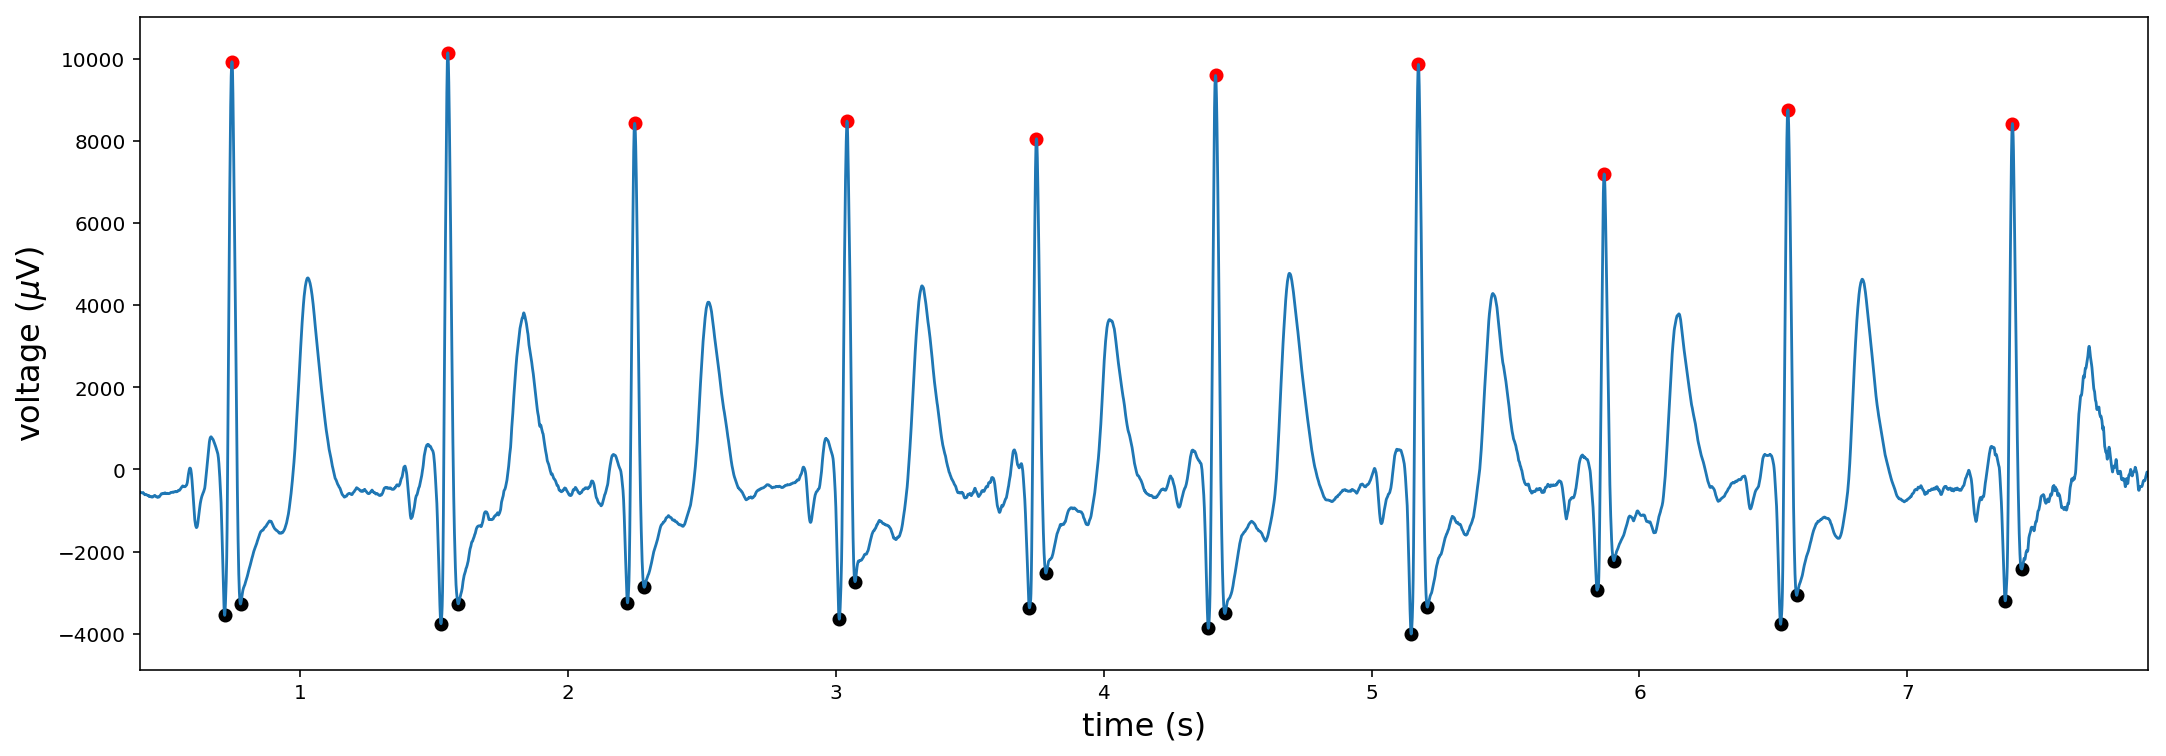

In [25]:
# Plotting
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timeECG),max(timeECG))
plt.plot(timeECG, waveData)
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.show()

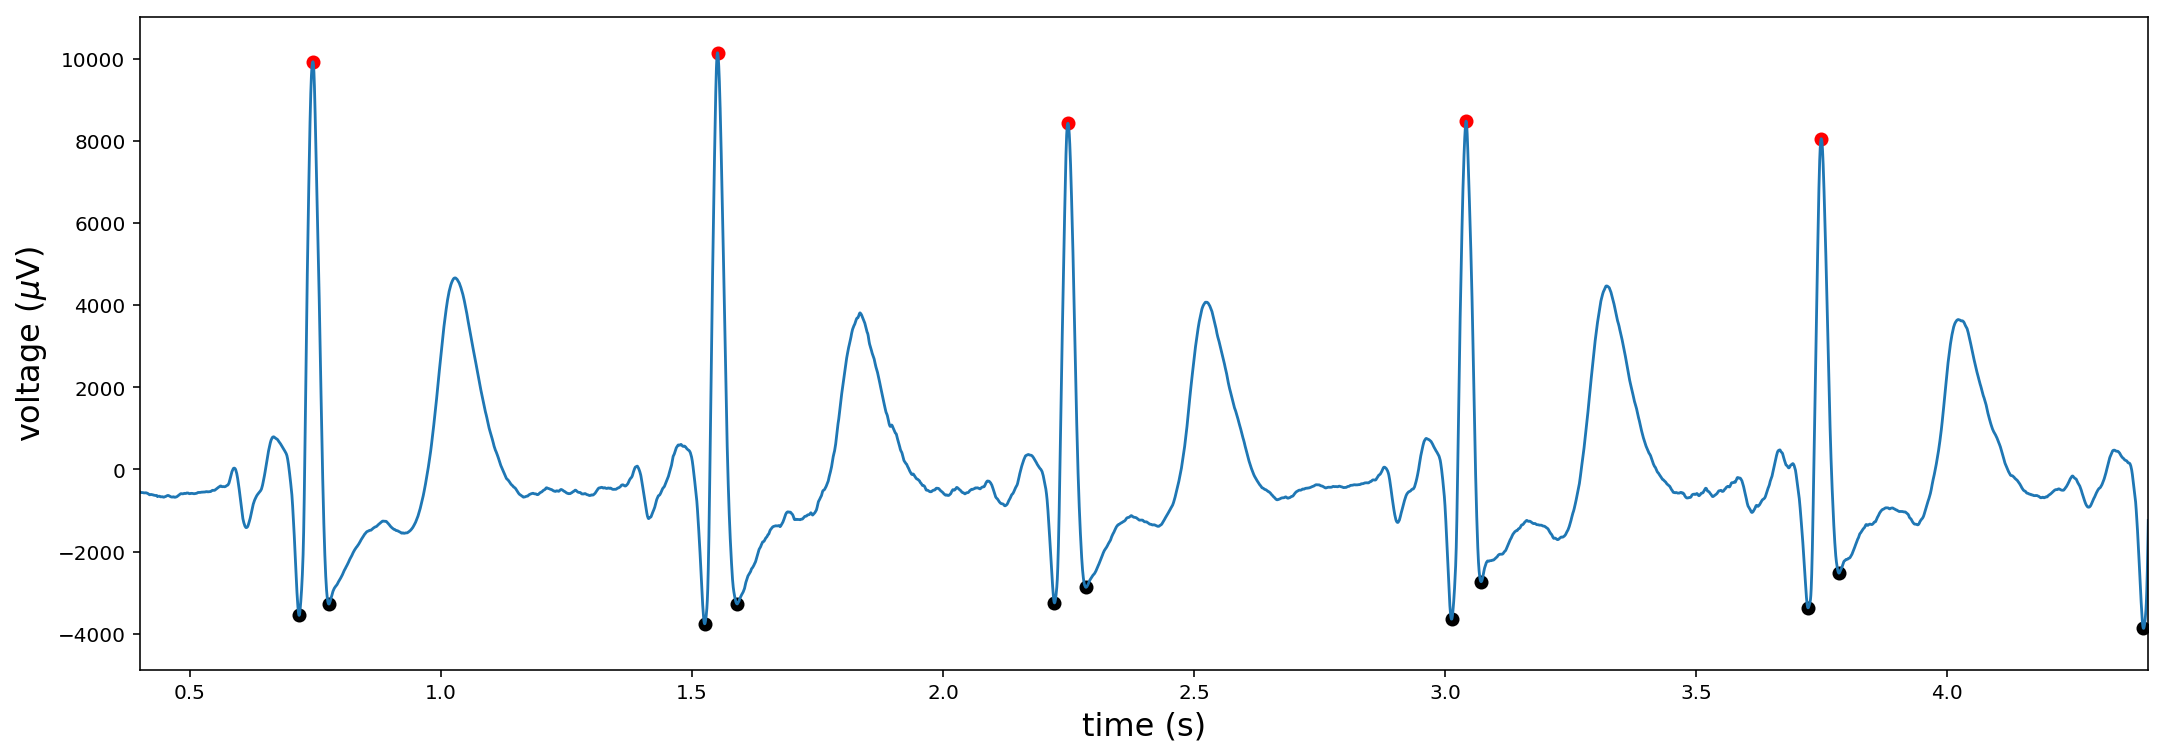

In [26]:
# Zoom
init_sec = 0
fin_sec = 4
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.show()

In [27]:
# What are the lengths of these QRS complexes?
qrs_length = np.zeros(len(mxs_indices))

for i in range(0, len(mxs_indices)):
    qrs_length[i] = timeECG[mins_try[i*2 + 1]] - timeECG[mins_try[i*2]]
    
mean_qrs = np.mean(qrs_length)
print("Mean in seconds of the QRS complex: ",mean_qrs)

mean_vec = [mean_qrs for i in range(0, len(qrs_length))]
std_vec_plus = [mean_qrs+stdev(qrs_length) for i in range(0, len(qrs_length))]
std_vec_minus = [mean_qrs-stdev(qrs_length) for i in range(0, len(qrs_length))]

Mean in seconds of the QRS complex:  0.06142031674324818


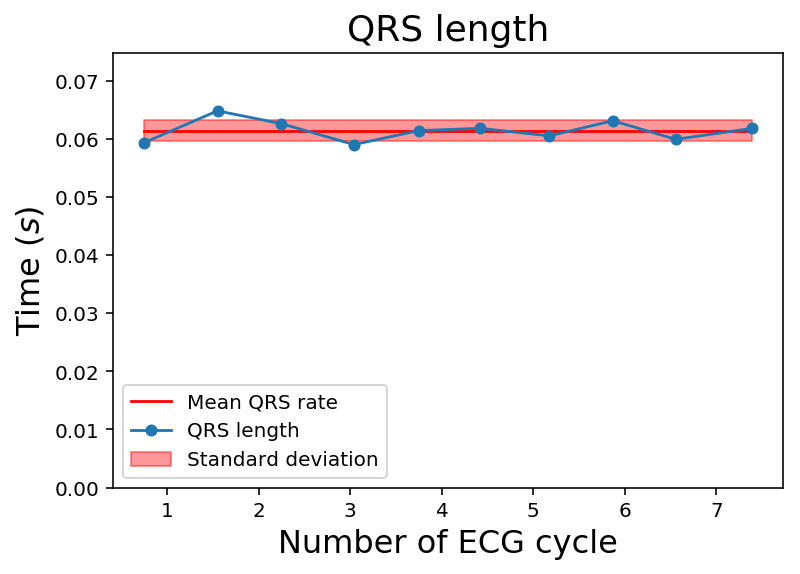

In [28]:
plt.fill_between(time, std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time, mean_vec, c="r", label = "Mean QRS rate")
plt.plot(time, qrs_length, markersize=5, marker = "o", label="QRS length")
plt.ylim((0, max(qrs_length)+0.01))
plt.title("QRS length")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

# P-wave

A healthy P-R interval is between: 0.12-0.20s [Cadogan, 2019]. Another reference stablishes that the PQ interval is between 0.12 and 0.20 seconds [ECGpedia, 2013].

So if we can start looking for the P wave 0.3 s before the R peak. There must be an inflection point, so we can obtain the discrete derivative of the time series.

In [29]:
nn = 3000 #0.3 seconds
p_wave_begin = []
interval_der = 200 #window for obtaining derivative
time_derivative_vec = []
for mxs_i in range(0, len(mxs_indices)):
    
    for i in range(0, nn-500):
        index = mins_try[mxs_i*2] - nn + i
        aux = (waveData[index+interval_der]-waveData[index])/(timeECG[index+interval_der] - timeECG[index])
        time_derivative_vec.append(aux) 

        if aux > 25000: #Move this parameter until you find the correct threshold
            p_wave_begin.append(index)
            break

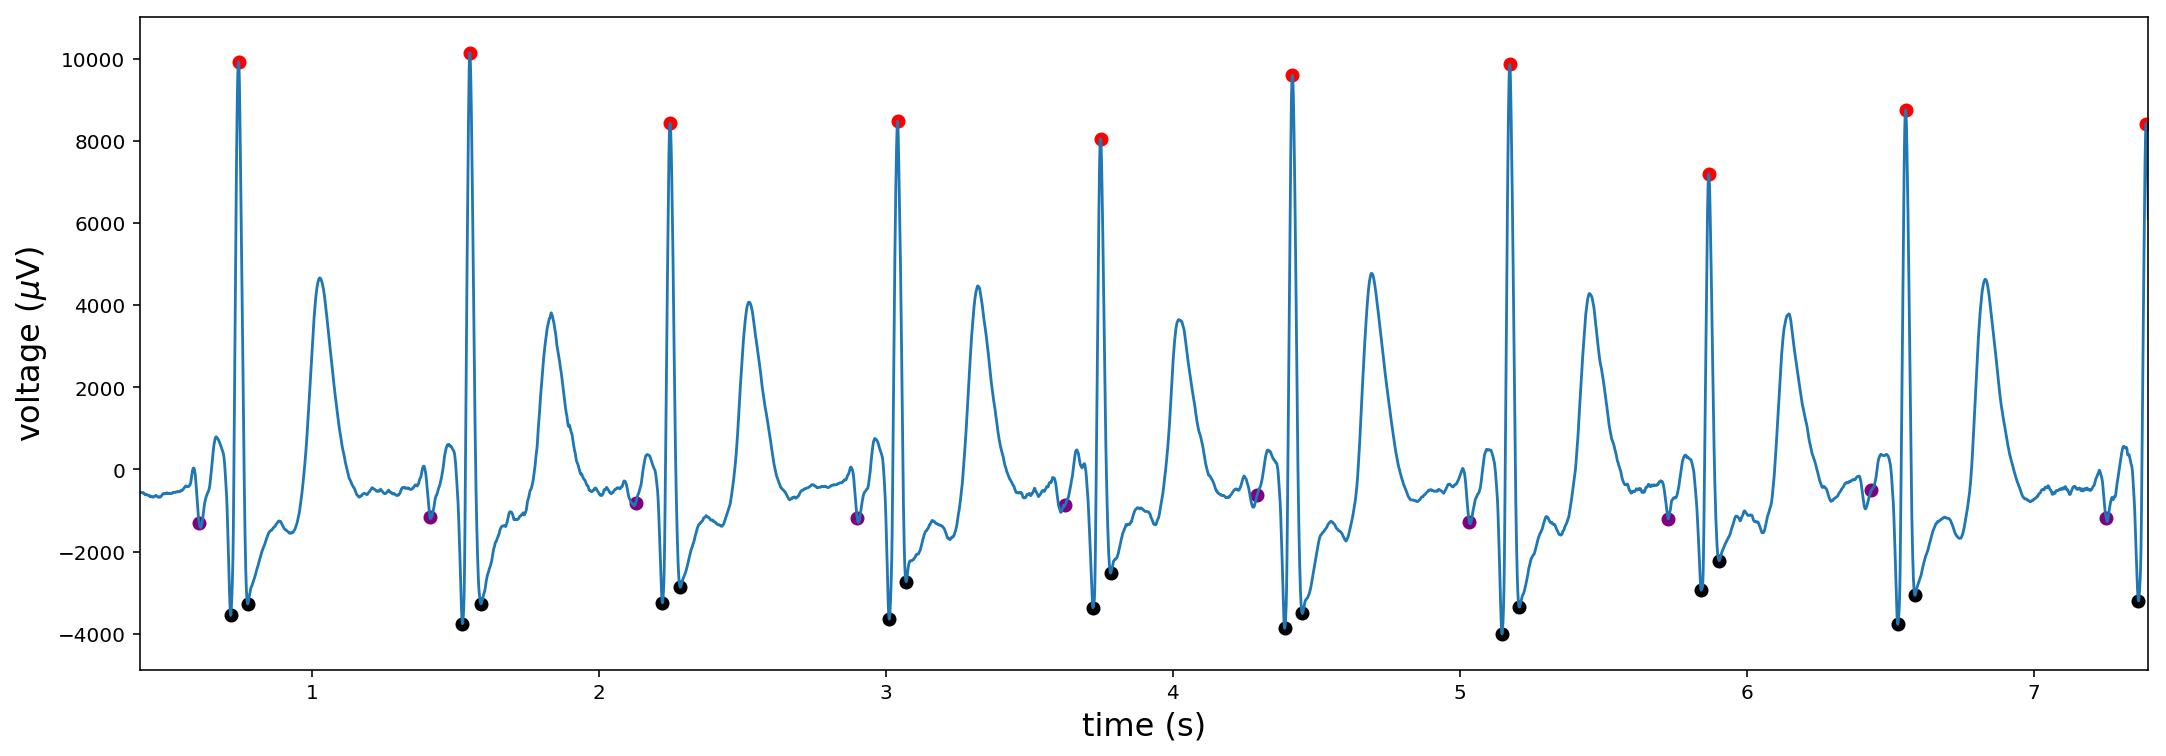

In [30]:
init_sec = 0
fin_sec = 7
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[p_wave_begin], waveData[p_wave_begin], color='purple')
plt.show()

Now we wish to find the end of the P wave.
We know that this will happen when the ECG signal has again the same value as in the start of the P wave.

In [31]:
p_wave_end = []
for p_wave_i in p_wave_begin:
    truth = False
    index = 200
    while truth == False:
        if waveData[p_wave_i+index] <= waveData[p_wave_i] and waveData[p_wave_i] > waveData[p_wave_i+index+1]:
            p_wave_end.append(p_wave_i+index)
            truth = True
        index +=1

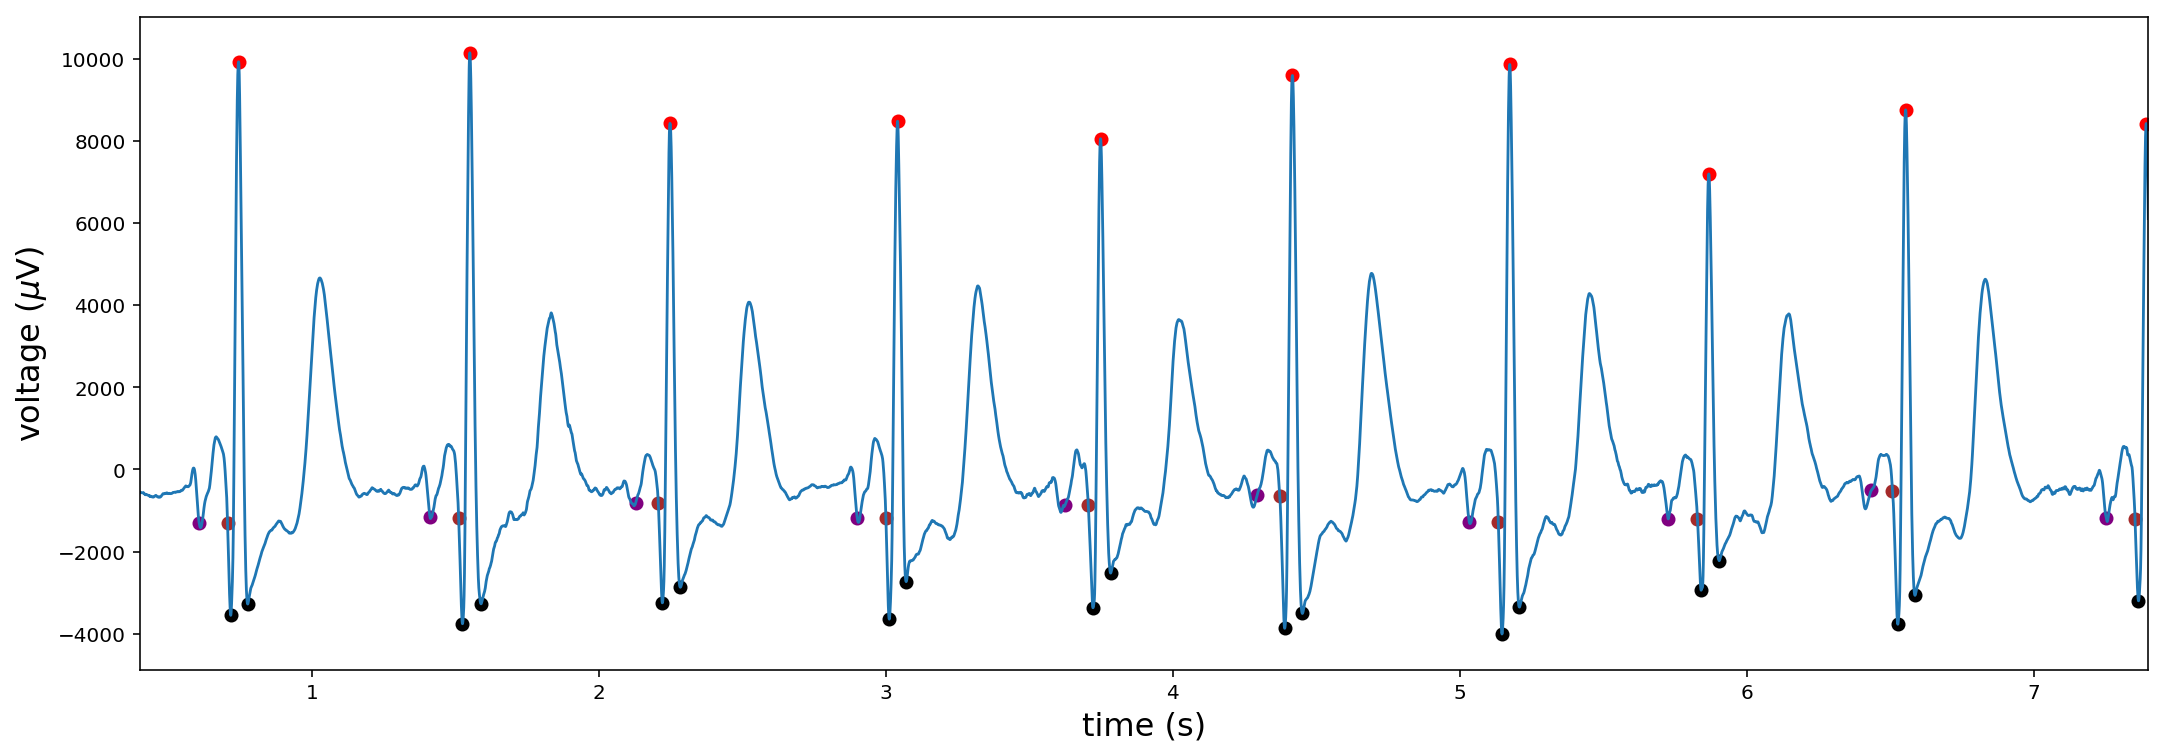

In [32]:
init_sec = 0
fin_sec = 7
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[p_wave_begin], waveData[p_wave_begin], color='purple')
plt.scatter(timeECG[p_wave_end], waveData[p_wave_end], color='brown')
plt.show()

In [33]:
# p wave intervals:
if len(p_wave_begin) != len(p_wave_end):
    print("Check the array lengths because they are different.")
    
p_wave_time = np.zeros(len(p_wave_begin)-1)
for i in range(1, len(p_wave_begin)):
    p_wave_time[i-1] = timeECG[p_wave_end[i]] - timeECG[p_wave_begin[i]]
    
mean_p_wave = np.mean(p_wave_time)
print("Mean in seconds of the P-wave: ",mean_p_wave)

mean_vec = [mean_p_wave for i in range(0, len(time)-1)]
std_vec_plus = [mean_p_wave+stdev(p_wave_time) for i in range(0, len(time)-1)]
std_vec_minus = [mean_p_wave-stdev(p_wave_time) for i in range(0, len(time)-1)]

Mean in seconds of the P-wave:  0.09061157839306573


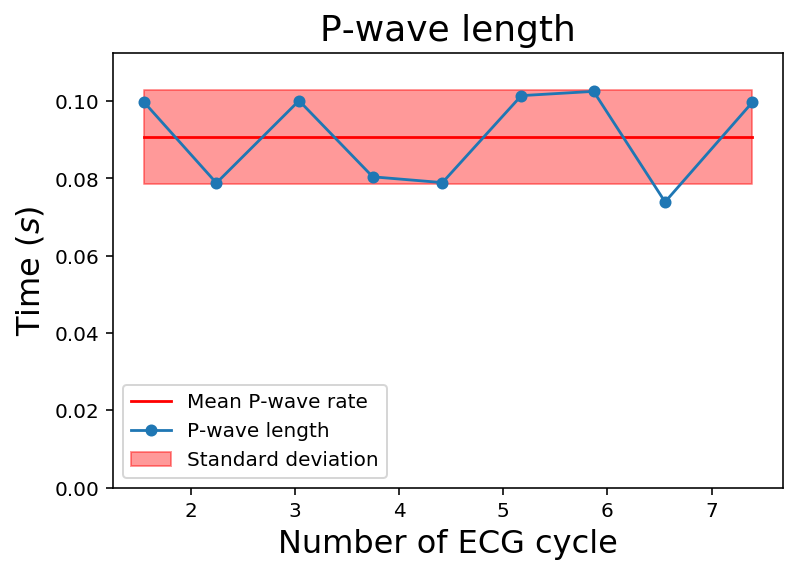

In [34]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean P-wave rate")
plt.plot(time[1:], p_wave_time, markersize=5, marker = "o", label="P-wave length")
plt.ylim((0, max(p_wave_time)+0.01))
plt.title("P-wave length")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

# T wave

The normal QT interval is below 450 ms for men and below 460 ms for women [ECGpedia, 2013]. Based on this, we will start looking for the T wave 300 ms after the R peak.

The duration of the T Wave is 0.10 to 0.25 seconds or greater [Nurses Learning, 1999].

In [35]:
nn = 1500 #0.15 seconds
t_wave_begin = []
interval_der = 200 #window for obtaining derivative
time_derivative_vec = []
for mxs_i in range(0, len(mxs_indices)):
    
    for i in range(0, nn-500):
        index = mins_try[mxs_i*2] + nn + i
        aux = (waveData[index+interval_der]-waveData[index])/(timeECG[index+interval_der] - timeECG[index])
        time_derivative_vec.append(aux) 

        if aux > 25000: #Move this parameter until you find the correct threshold
            t_wave_begin.append(index)
            break

For identifying the end of the T wave we will also consider an inflection point. We are not using the same idea as in the end of the P wave because when looking at the graphs, the end of the T wave does not have the same value as the beginning of the T wave. This is because the recording does not have a stable baseline.

In [36]:
# t_wave_end
nn = 3000 #0.3 seconds
t_wave_end = []
interval_der = 100 #window for obtaining derivative
time_derivative_vec = [0]
for mxs_i in range(0, len(mxs_indices)):
    
    for i in range(0, nn-500):
        index = mins_try[mxs_i*2] + nn + i
        aux = (waveData[index+interval_der]-waveData[index])/(timeECG[index+interval_der] - timeECG[index])
        time_derivative_vec.append(aux) 

        if time_derivative_vec[i] > 0 and time_derivative_vec[i-1] < 0: #Move this parameter until you find the correct threshold
        #We are looking for the inflection point where the derivative changes from being negative to being positive
            t_wave_end.append(index)
            break

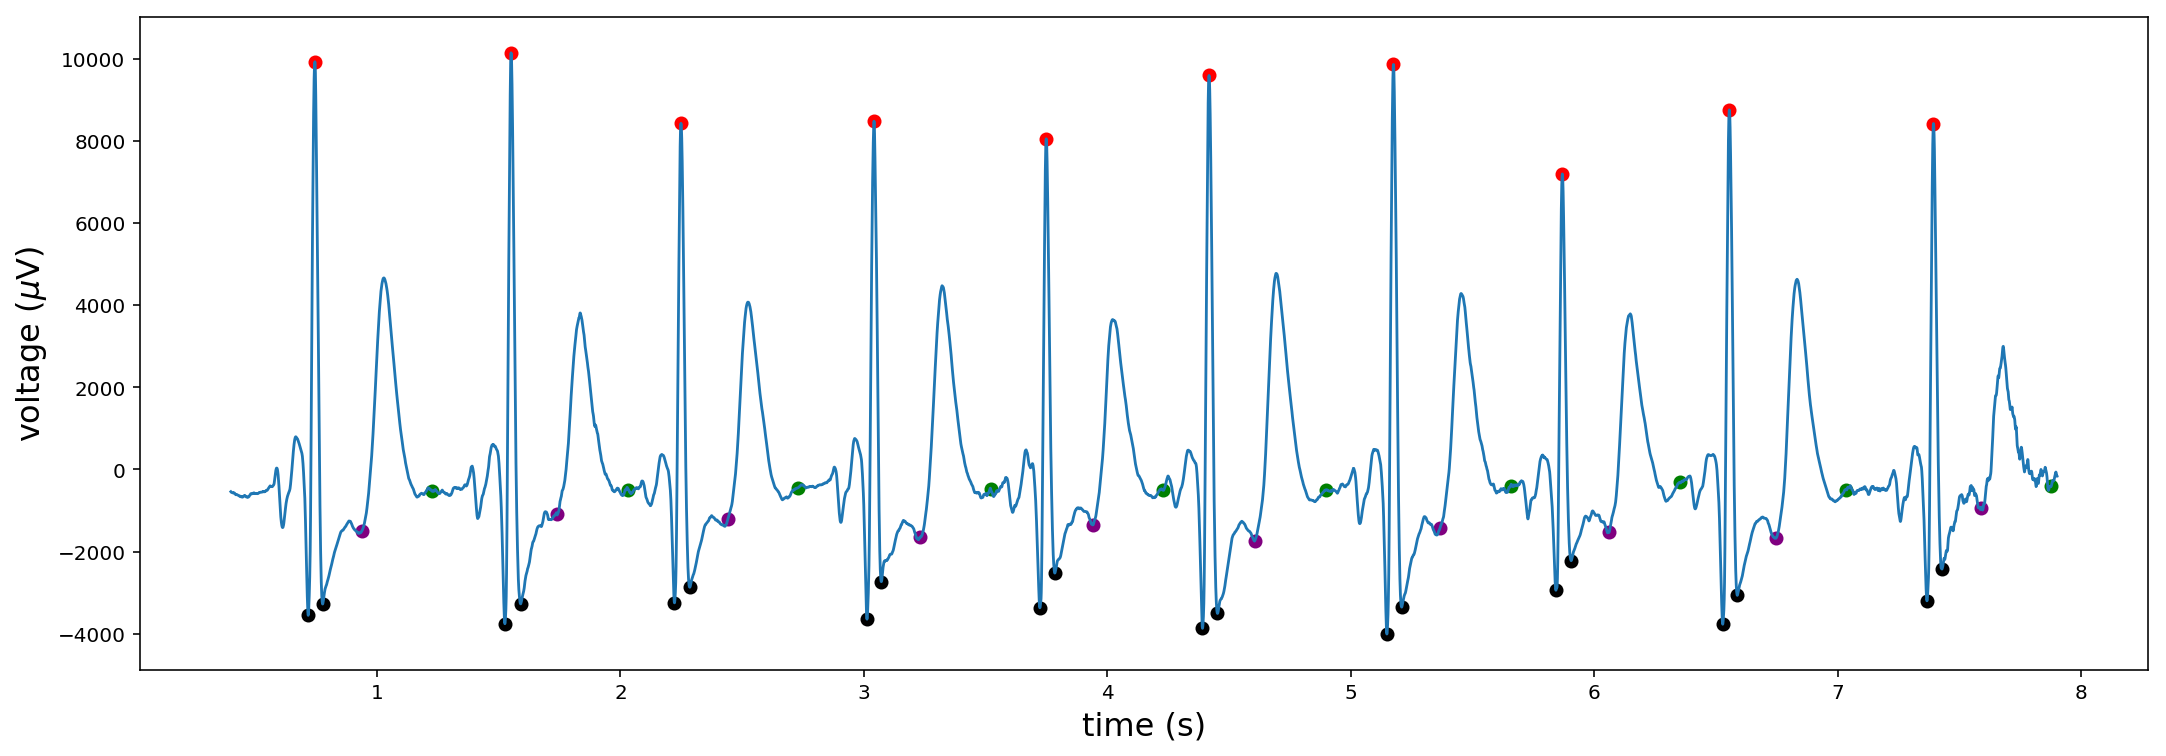

In [37]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG, waveData)
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[t_wave_begin], waveData[t_wave_begin], color='purple')
plt.scatter(timeECG[t_wave_end], waveData[t_wave_end], color='green')
plt.show()

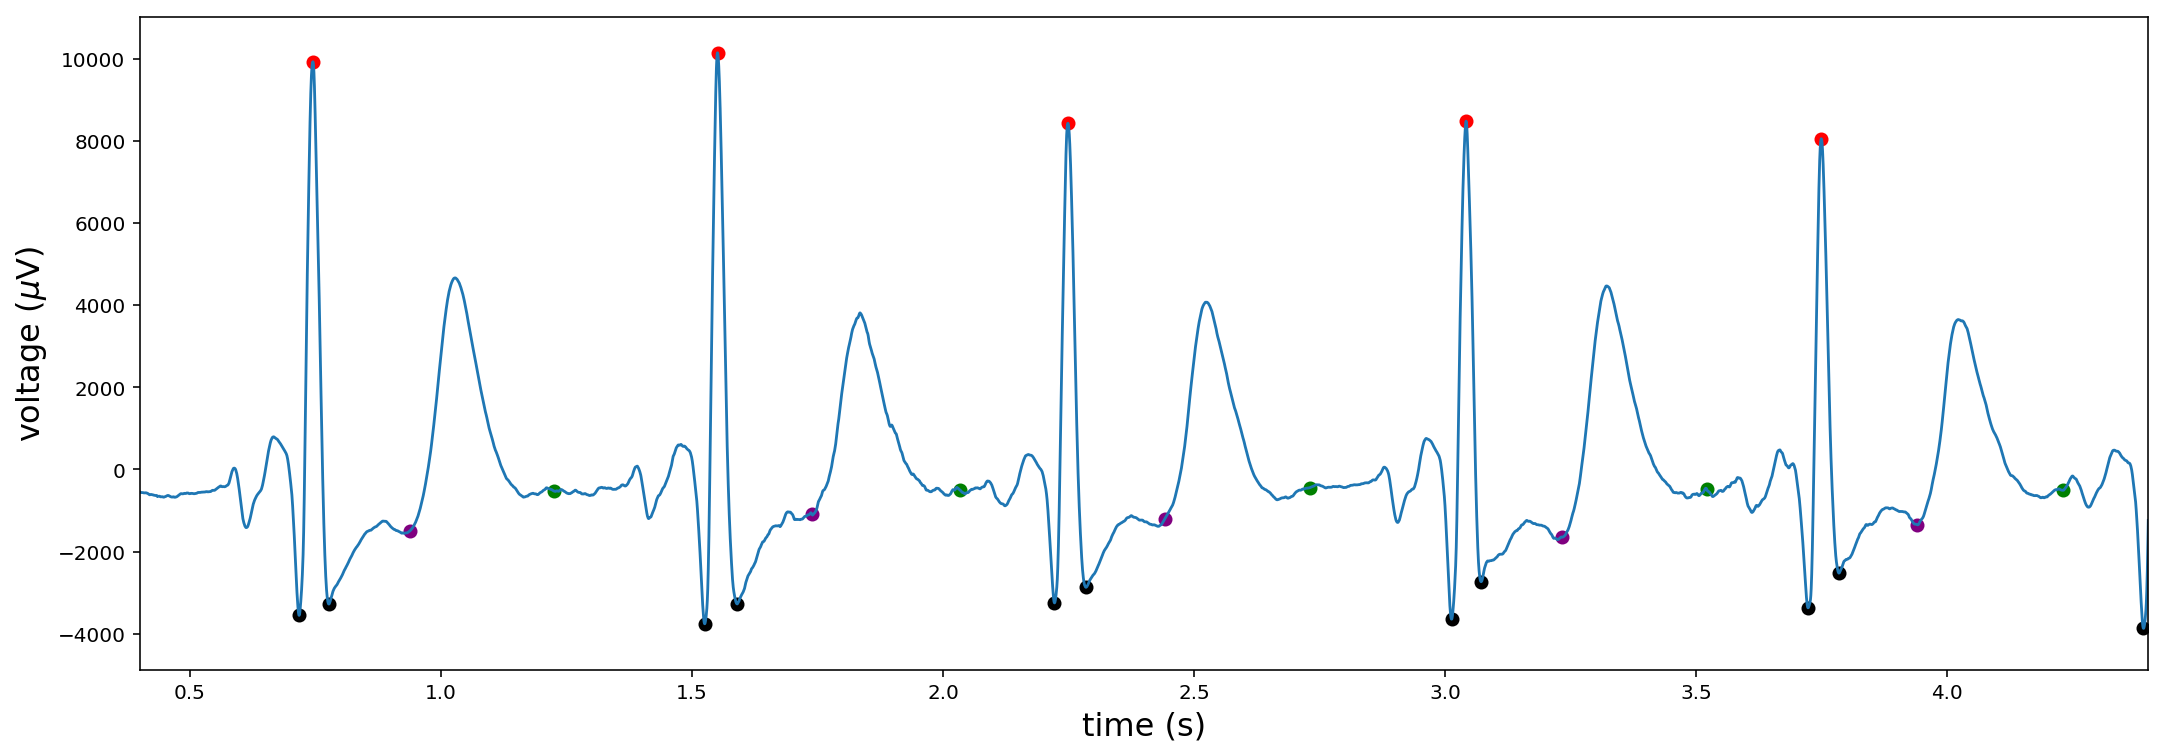

In [38]:
#Close up
init_sec = 0
fin_sec = 4
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[t_wave_begin], waveData[t_wave_begin], color='purple')
plt.scatter(timeECG[t_wave_end], waveData[t_wave_end], color='green')
plt.show()

In [39]:
# t wave intervals:
if len(t_wave_begin) != len(t_wave_end):
    print("Check the array lengths because they are different.")
    
t_wave_time = np.zeros(len(t_wave_begin)-1)
for i in range(1, len(t_wave_begin)):
    t_wave_time[i-1] = timeECG[t_wave_end[i]] - timeECG[t_wave_begin[i]]
    
# Mean time for t wave
mean_t_wave = np.mean(t_wave_time)
print("Mean in seconds of the T-wave: ",mean_t_wave)

mean_vec = [mean_t_wave for i in range(0, len(time)-1)]
std_vec_plus = [mean_t_wave+stdev(t_wave_time) for i in range(0, len(time)-1)]
std_vec_minus = [mean_t_wave-stdev(t_wave_time) for i in range(0, len(time)-1)]

Mean in seconds of the T-wave:  0.29012371838397794


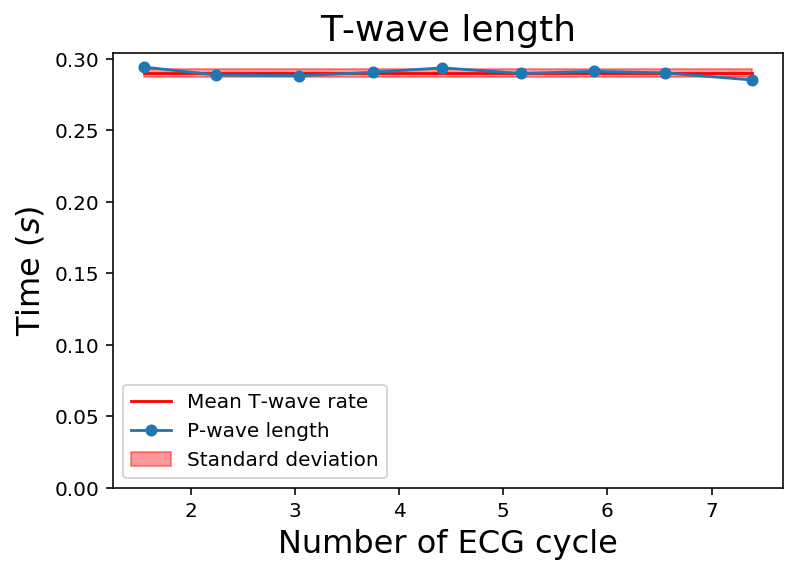

In [40]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean T-wave rate")
plt.plot(time[1:], t_wave_time, markersize=5, marker = "o", label="P-wave length")
plt.ylim((0, max(t_wave_time)+0.01))
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.title("T-wave length")
plt.legend()
plt.show()

This is in agreent that the T-wave lasts 0.1 to 0.25 seconds or more [Nurses Learning, 1999].

# References

[BackyardBrains, 2017] BackyardBrains (2009-2017). Experiment: Heart Action Potentials. https://backyardbrains.com/experiments/heartrate. Accessed December 20, 2019.

[Boron and Boulpaep, 2012] Boron, W. F. and Boulpaep, E. L. (2012). Medical physiology, 2e updated edition e-book: with student consult online access. Elsevier health sciences.

[Cadogan, 2019] Cadogan, M. (2019). PR Interval. https://litfl.com/pr-interval-ecg-library/ Accessed May 8, 2020.

[ECGpedia, 2013] ECGpedia (2013). Conduction. https://en.ecgpedia.org/wiki/Conduction. Accessed May 7, 2020.

[Kantz and Schreiber, 2004] Kantz, H. and Schreiber, T. (2004). Nonlinear time series analysis, volume 7. Cambridge university press.

[Larkin, 2019] Larkin, J. (2019). QRS Interval. https://litfl.com/qrs-interval-ecg-library/. Accessed May 8, 2020.

[Nurses Learning, 1999] Nurses Learning (1999). EKG Interpretation. https://www.nurseslearning.com/courses/nrp/nrp1619/Section%202/index.htm. Accessed May 7, 2020.